In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [4]:
temp = pd.read_csv('temp.csv')

In [6]:
temp.head()

,Temperature - (Celsius),Year,Month
0,7.72768,1901,January
1,8.93600,1901,February
2,16.96320,1901,March
3,21.27410,1901,April
4,26.04970,1901,May


In [8]:
temp.isna().sum()

Temperature - (Celsius)    0
 Year                      0
Month                      0
dtype: int64

In [12]:
temp.columns = temp.columns.str.strip()

In [14]:
# Create Date column and set it as index
temp['Date'] = pd.to_datetime(temp['Year'].astype(str) + '-' + temp['Month'] + '-01')
temp.set_index('Date', inplace=True)
temp.drop(columns=['Year', 'Month'], inplace=True)

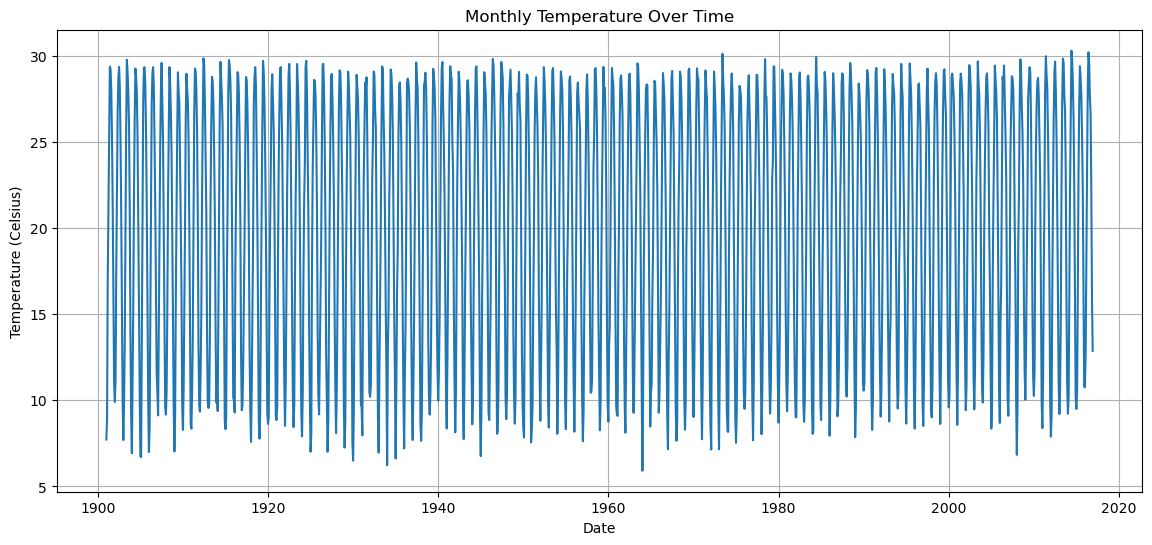

In [16]:
# Plot the full temperature data
plt.figure(figsize=(14,6))
plt.plot(temp.index, temp['Temperature - (Celsius)'])
plt.title('Monthly Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.grid(True)
plt.show()

In [18]:
# Split into training (80%) and testing (20%)
train_size = int(len(temp) * 0.8)
train = temp.iloc[:train_size]
test = temp.iloc[train_size:]

In [20]:
print("Training set shape:", train.shape)
print("Testing set shape:", test.shape)

Training set shape: (1113, 1)
Testing set shape: (279, 1)


In [22]:
# ADF Test (check stationarity)
result = adfuller(train['Temperature - (Celsius)'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -6.46765655319358
p-value: 1.3922598382046324e-08


ARIMA Model

In [25]:
# Fit ARIMA model
model = ARIMA(train['Temperature - (Celsius)'], order=(2, 0, 2))
model_fit = model.fit()

In [27]:
# Predict on test data
predictions = model_fit.predict(start=test.index[0], end=test.index[-1])

In [31]:
# Calculate ARIMA metrics
rmse_arima = np.sqrt(mean_squared_error(test['Temperature - (Celsius)'], predictions))
mae_arima = mean_absolute_error(test['Temperature - (Celsius)'], predictions)
mape_arima = np.mean(np.abs((test['Temperature - (Celsius)'] - predictions) / test['Temperature - (Celsius)'])) * 100
print('ARIMA RMSE:', rmse_arima)
print('ARIMA MAE:', mae_arima)
print('ARIMA MAPE:', mape_arima)

ARIMA RMSE: 4.283241479876491
ARIMA MAE: 3.5963814759737085
ARIMA MAPE: 21.76399355579903


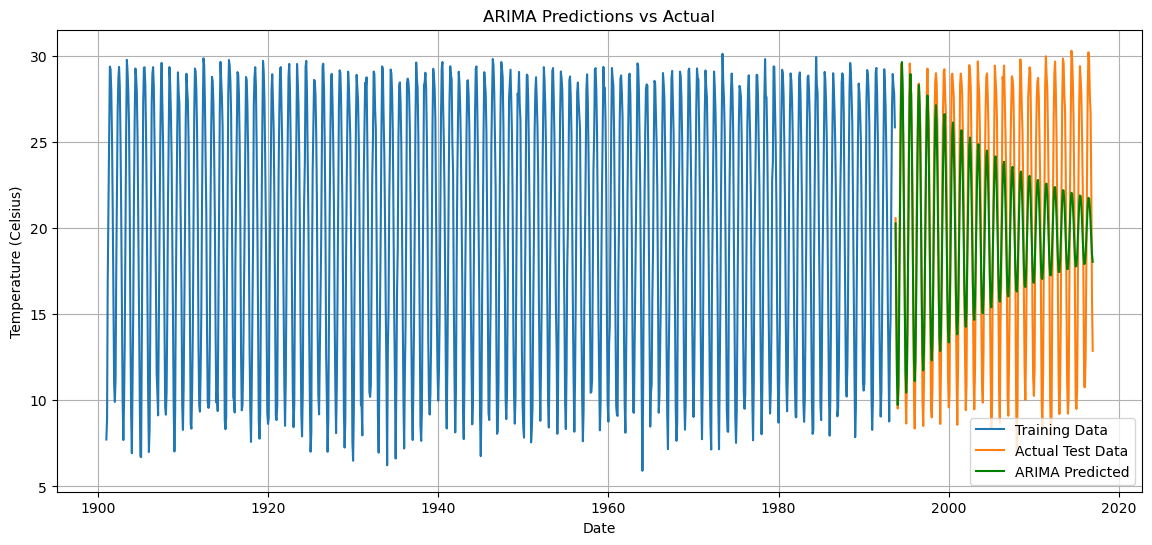

In [35]:
# Plot ARIMA predictions vs actual
plt.figure(figsize=(14,6))
plt.plot(train.index, train['Temperature - (Celsius)'], label='Training Data')
plt.plot(test.index, test['Temperature - (Celsius)'], label='Actual Test Data')
plt.plot(predictions.index, predictions, label='ARIMA Predicted', color='green')
plt.title('ARIMA Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.legend()
plt.grid(True)
plt.show()

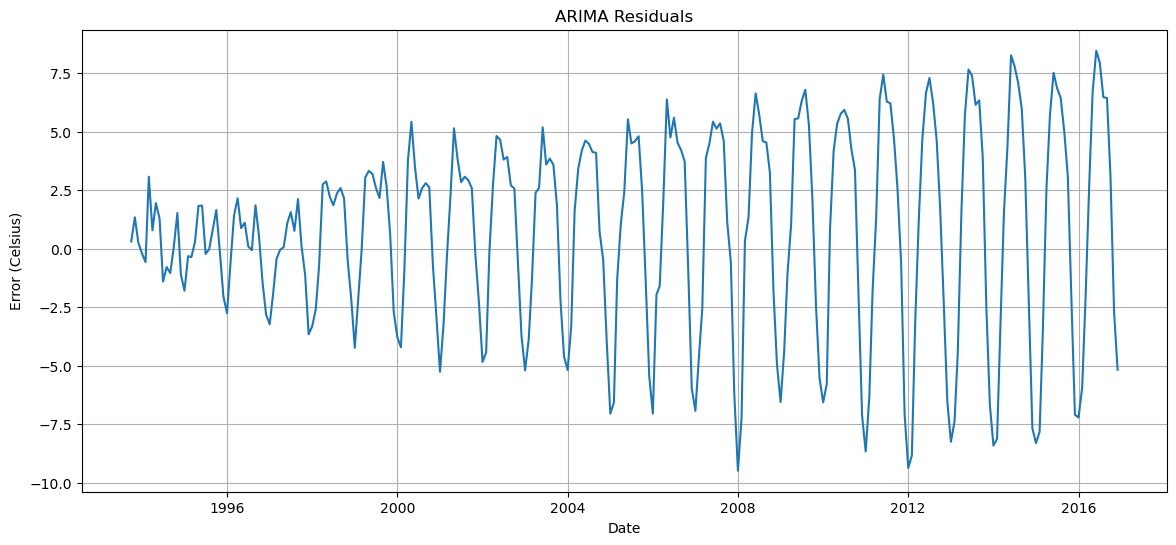

In [38]:
# Plot ARIMA residuals
arima_residuals = test['Temperature - (Celsius)'] - predictions

plt.figure(figsize=(14,6))
plt.plot(arima_residuals)
plt.title('ARIMA Residuals')
plt.xlabel('Date')
plt.ylabel('Error (Celsius)')
plt.grid(True)
plt.show()

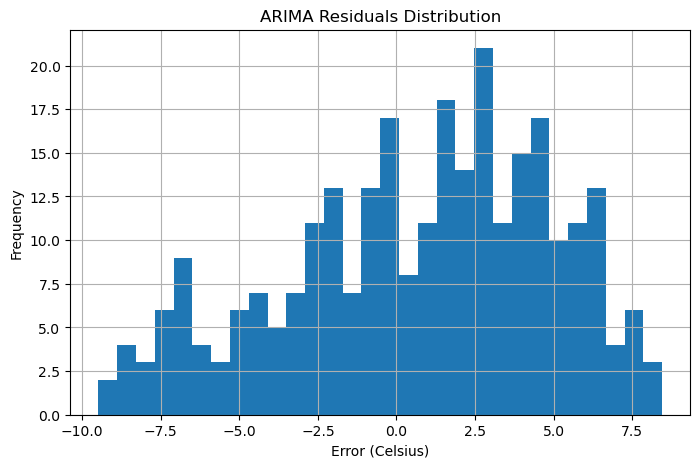

In [40]:
plt.figure(figsize=(8,5))
plt.hist(arima_residuals, bins=30)
plt.title('ARIMA Residuals Distribution')
plt.xlabel('Error (Celsius)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The ARIMA Predictions vs Actual shows that our models is not very good on predicting. Therefore we will try SARIMA.

SARIMA Model

In [44]:
# Fit SARIMA model
sarima_model = SARIMAX(train['Temperature - (Celsius)'], order=(2, 0, 2), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46293D+00    |proj g|=  2.83733D-01


 This problem is unconstrained.



At iterate    5    f=  1.36452D+00    |proj g|=  4.47098D-02

At iterate   10    f=  1.35576D+00    |proj g|=  5.44482D-03

At iterate   15    f=  1.35540D+00    |proj g|=  8.52190D-04

At iterate   20    f=  1.35525D+00    |proj g|=  5.06054D-03

At iterate   25    f=  1.35522D+00    |proj g|=  1.03781D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     34      1     0     0   1.023D-05   1.355D+00
  F =   1.3552208185896759     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [46]:
# Predict on test data
sarima_predictions = sarima_fit.predict(start=test.index[0], end=test.index[-1])

In [50]:
# Calculate SARIMA metrics
rmse_sarima = np.sqrt(mean_squared_error(test['Temperature - (Celsius)'], sarima_predictions))
mae_sarima = mean_absolute_error(test['Temperature - (Celsius)'], sarima_predictions)
mape_sarima = np.mean(np.abs((test['Temperature - (Celsius)'] - sarima_predictions) / test['Temperature - (Celsius)'])) * 100
print('SARIMA RMSE:', rmse_sarima)
print('SARIMA MAE:', mae_sarima)
print('SARIMA MAPE:', mape_sarima)

SARIMA RMSE: 1.1338837762695333
SARIMA MAE: 0.8581145846512008
SARIMA MAPE: 4.8805901771803955


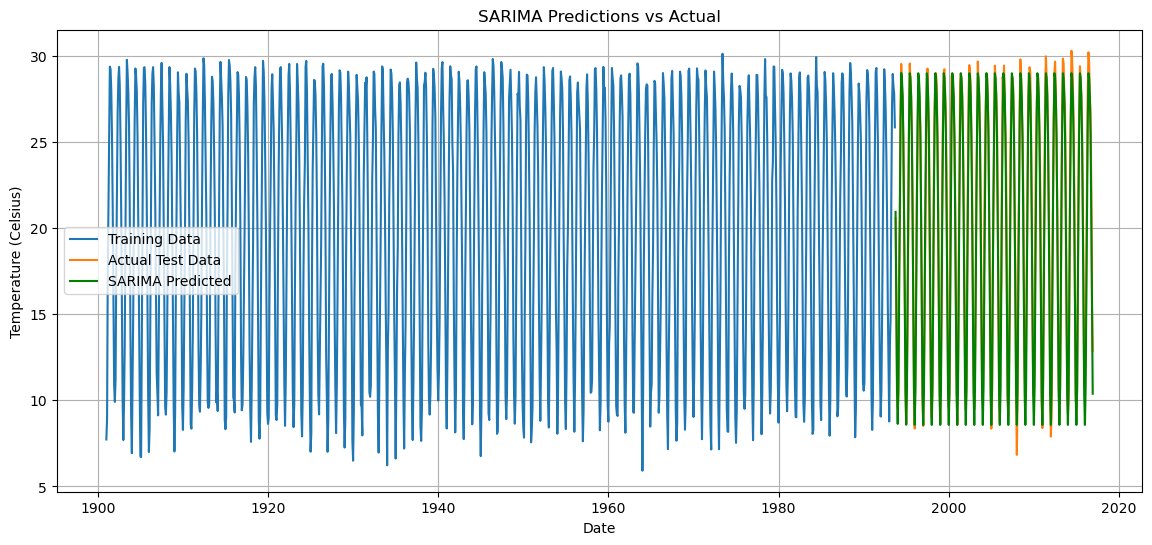

In [52]:
# Plot SARIMA predictions vs actual
plt.figure(figsize=(14,6))
plt.plot(train.index, train['Temperature - (Celsius)'], label='Training Data')
plt.plot(test.index, test['Temperature - (Celsius)'], label='Actual Test Data')
plt.plot(sarima_predictions.index, sarima_predictions, label='SARIMA Predicted', color='green')
plt.title('SARIMA Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.legend()
plt.grid(True)
plt.show()

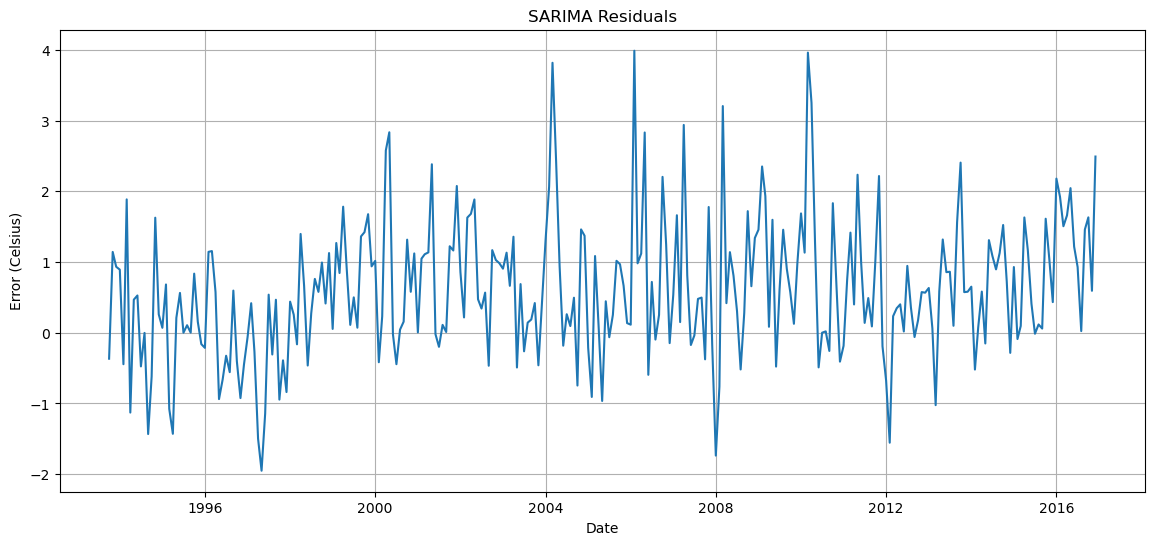

In [54]:
# Plot SARIMA residuals
sarima_residuals = test['Temperature - (Celsius)'] - sarima_predictions

plt.figure(figsize=(14,6))
plt.plot(sarima_residuals)
plt.title('SARIMA Residuals')
plt.xlabel('Date')
plt.ylabel('Error (Celsius)')
plt.grid(True)
plt.show()

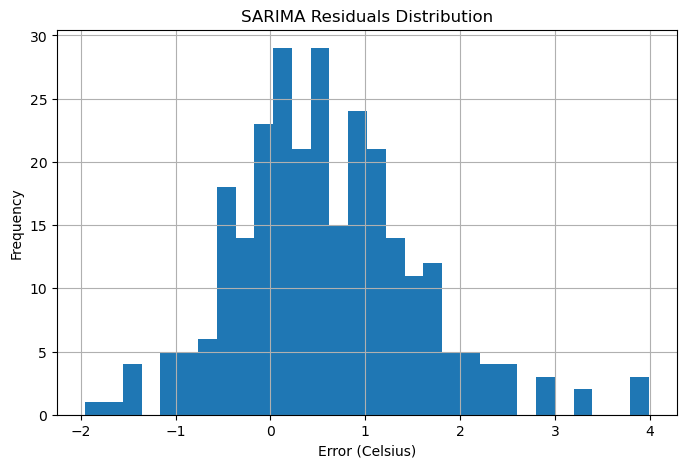

In [56]:
plt.figure(figsize=(8,5))
plt.hist(sarima_residuals, bins=30)
plt.title('SARIMA Residuals Distribution')
plt.xlabel('Error (Celsius)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Our plot and the metrics score shows that our SARIMA model performed a lot better on predicting than ARIMA.

Exponential Smoothing Model

In [62]:
# Fit Exponential Smoothing model
ex_model = ExponentialSmoothing(train['Temperature - (Celsius)'], seasonal='add', seasonal_periods=12)
ex_fit = ex_model.fit()

In [66]:
# Predict on test data
ex_predictions = ex_fit.predict(start=test.index[0], end=test.index[-1])

In [70]:
# Calculate Exponential Smoothing metrics
rmse_hw = np.sqrt(mean_squared_error(test['Temperature - (Celsius)'], ex_predictions))
mae_hw = mean_absolute_error(test['Temperature - (Celsius)'], ex_predictions)
mape_hw = np.mean(np.abs((test['Temperature - (Celsius)'] - ex_predictions) / test['Temperature - (Celsius)'])) * 100

In [72]:
print('Exponential Smoothing RMSE:', rmse_hw)
print('Exponential Smoothing MAE:', mae_hw)
print('Exponential Smoothing MAPE:', mape_hw)

Exponential Smoothing RMSE: 1.0747761580357544
Exponential Smoothing MAE: 0.81330183087714
Exponential Smoothing MAPE: 4.682108988798907


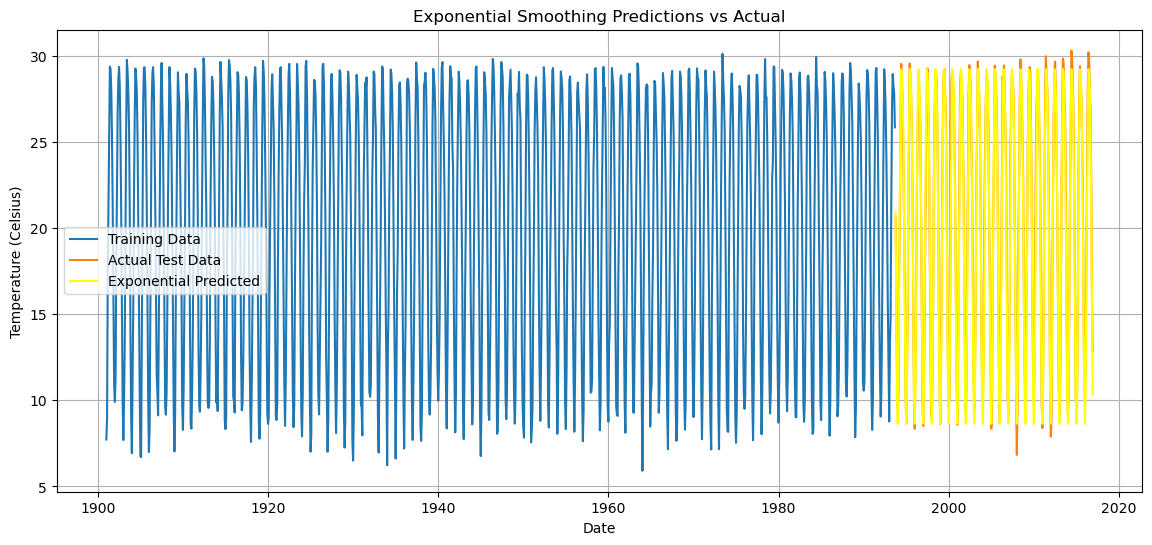

In [78]:
# Plot Exponential Smoothing predictions vs actual
plt.figure(figsize=(14,6))
plt.plot(train.index, train['Temperature - (Celsius)'], label='Training Data')
plt.plot(test.index, test['Temperature - (Celsius)'], label='Actual Test Data')
plt.plot(ex_predictions.index, ex_predictions, label='Exponential Predicted', color='yellow')
plt.title('Exponential Smoothing Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
# Plot Exponential Smoothing residuals
ex_residuals = test['Temperature - (Celsius)'] - ex_predictions

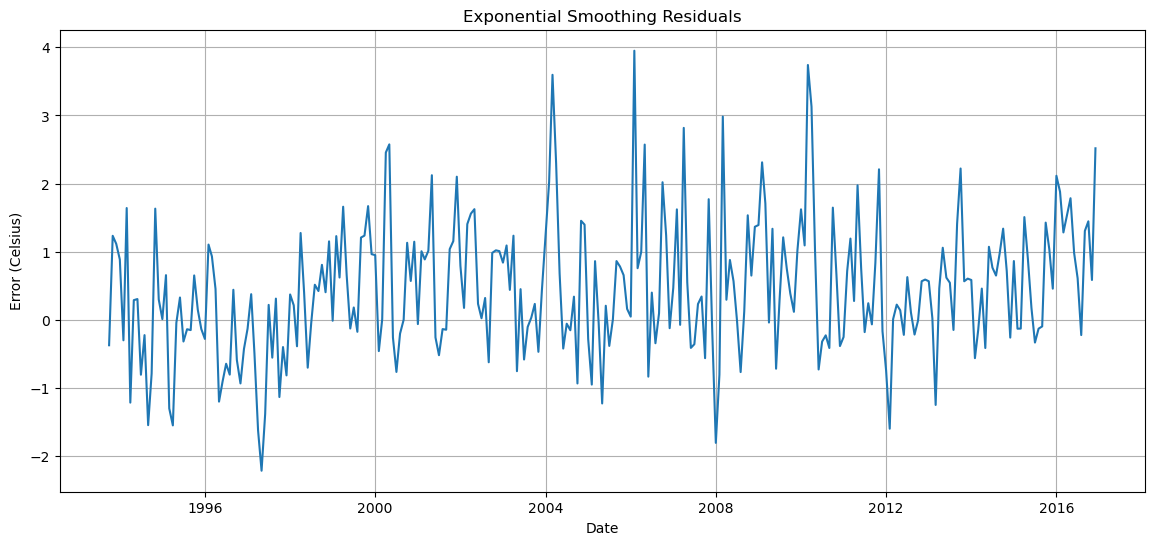

In [84]:
plt.figure(figsize=(14,6))
plt.plot(ex_residuals)
plt.title('Exponential Smoothing Residuals')
plt.xlabel('Date')
plt.ylabel('Error (Celsius)')
plt.grid(True)
plt.show()

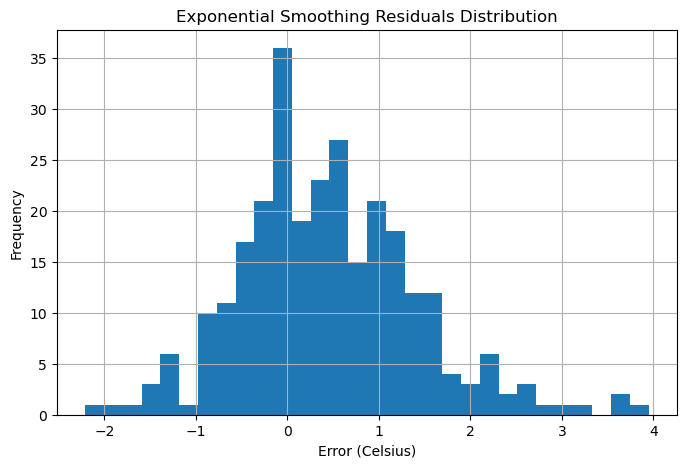

In [86]:
plt.figure(figsize=(8,5))
plt.hist(ex_residuals, bins=30)
plt.title('Exponential Smoothing Residuals Distribution')
plt.xlabel('Error (Celsius)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Based on the plot and evaluation metrics, the Exponential Smoothing method performed better compared to both the ARIMA and SARIMA models. While there was a significant difference between Exponential Smoothing and ARIMA, the diffrence between Exponential Smoothing and SARIMA was relatively small.